In [2]:
try:
  import distrax
except ModuleNotFoundError:
  %pip install distrax
  import distrax
try:
  import jax
except ModuleNotFoundError:
  %pip install jax 
  import jax

import jax.numpy as jnp
try:
  import matplotlib.pyplot as plt
except ModuleNotFoundError:
  %pip install matplotlib 
  import matplotlib.pyplot as plt

key = jax.random.PRNGKey(42)
jax.config.update("jax_enable_x64", True)

try:
  import GPy
except ModuleNotFoundError:
  %pip install GPy
  import GPy

try:
  from tqdm import tqdm
except ModuleNotFoundError:
  %pip install tqdm
  from tqdm import tqdm


try: 
  import jaxopt
except ModuleNotFoundError:
  %pip install jaxopt
  import jaxopt

import optax
from sklearn.neighbors import NearestNeighbors

2022-06-10 11:32:13.569389: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
import pickle
# Load in the data
with open("/mnt/c/Users/acer/Desktop/Summer2022/IITGN/Gaussian Process/mauna_loa", "rb") as fid:
    print(fid)
    data = pickle.load(fid)
    
print("\nData keys:")
print(data.keys())

print("\nCitation:")
print(data['citation'])

print("\nInfo:")
print(data['info'])

<_io.BufferedReader name='/mnt/c/Users/acer/Desktop/Summer2022/IITGN/Gaussian Process/mauna_loa'>

Data keys:
dict_keys(['X', 'Y', 'Xtest', 'Ytest', 'info', 'citation', 'details', 'files', 'license', 'size', 'urls'])

Citation:
Mauna Loa Data. Dr. Pieter Tans, NOAA/ESRL (www.esrl.noaa.gov/gmd/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

Info:
Mauna Loa data with 545 values used as training points.


float64 (545, 1)
(185, 1) (185, 1)


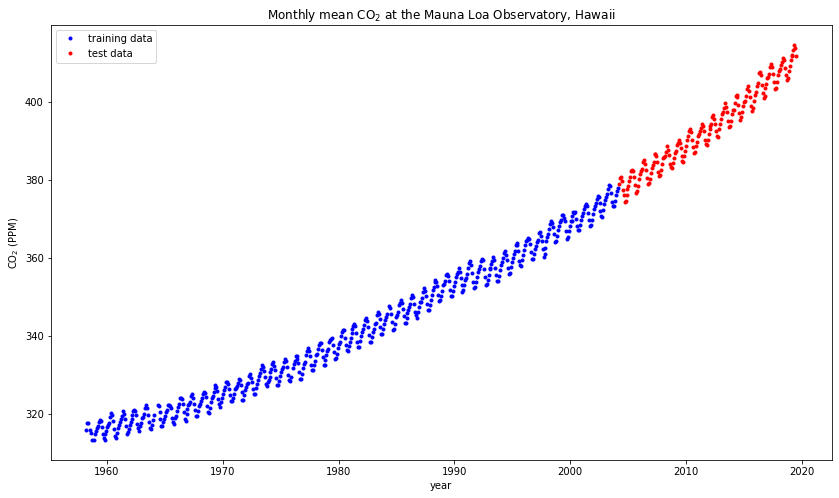

In [4]:
# Training data (X = input, Y = observation)
X, Y = data['X'], data['Y']
print(X.dtype,Y.shape)

# Test data (Xtest = input, Ytest = observations)
Xtest, Ytest = data['Xtest'], data['Ytest']
print(Xtest.shape,Ytest.shape)
# Set up our plotting environment
plt.figure(figsize=(14, 8))

# Plot the training data in blue and the test data in red
plt.plot(X, Y, "b.", Xtest, Ytest, "r.")

# Annotate plot
plt.legend(labels=["training data", "test data"])
plt.xlabel("year"), plt.ylabel("CO$_2$ (PPM)"), plt.title("Monthly mean CO$_2$ at the Mauna Loa Observatory, Hawaii");

X = X[::2, :]
Y = Y[::2, :]

X = jnp.array(X)
Y = jnp.array(Y)

In [5]:
def prior_samples(x, key):

  def rbf(x, x_star, len_scale, sigmaf):
    return (sigmaf**2)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  
    
  cov = rbf(X, X.T, 0.1, 1)
  mean_vec = jnp.zeros(X.shape[0])
  prior = distrax.MultivariateNormalFullCovariance(mean_vec,cov)
  f_prior = prior.sample(seed=key, sample_shape = (10,))
  f_prior = f_prior.T
  return f_prior

Text(0.5, 1.0, '10 prior samples ')

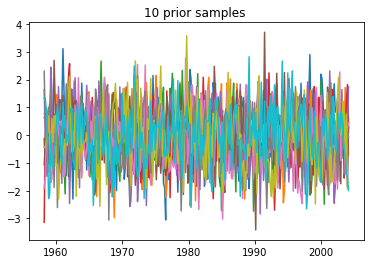

In [6]:
f_prior = prior_samples(X, key)
fig = plt.figure()
plt.plot(X, f_prior)
plt.title("10 prior samples ")
# plt.savefig('prior_sample.png')

In [7]:
class GP_Regression:

  def rbf(self, x, x_star, len_scale,varf):
    return (varf)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  
    
  def periodic_kernel(self, x, xstar, len_scale, varf, period):
    return (varf)*(jnp.exp((-1/2*(len_scale**2)) * jnp.square(jnp.sin(jnp.pi * (x-xstar)/period))))  


  def train(self,theta,data):
    X, y = data
    self.len_scale = jnp.exp(theta["log_scale"])
    self.varf = jnp.exp(theta["log_varf"])
    k = self.rbf(X,X.T,self.len_scale, self.varf)
    self.k = k + ( jnp.exp(theta["log_vary"]) * jnp.eye(len(X)))
    mean_vec= jnp.zeros(y.shape[0])
    dist = distrax.MultivariateNormalFullCovariance(mean_vec, self.k)
    dist_logprob = dist.log_prob(y.reshape(-1,))
    return -dist_logprob
  

  def posterior(self, X, y, X_test, mu_prior):
    L = jnp.linalg.cholesky(self.k)
    kstar = self.rbf(X, X_test.T, self.len_scale, self.varf)
    kstar_star = self.rbf(X_test, X_test.T, self.len_scale, self.varf)
    # posterior mean
    alpha = jnp.linalg.solve(L.T, (jnp.linalg.solve(L, (y - mu_prior))))
    self.mu_posterior =  mu_prior + jnp.dot(kstar.T, alpha)
    # posterior covarinace
    v = jnp.linalg.solve(L, kstar)
    self.cov_posterior = kstar_star - jnp.dot(v.T, v)
    return self.mu_posterior, self.cov_posterior

  def posterior_samples(self, key):
    # prior mean equal to zero
    print(self.mu_posterior.shape)
    posterior = distrax.MultivariateNormalFullCovariance(self.mu_posterior.reshape(-1,),self.cov_posterior)
    f_post = posterior.sample(seed=key, sample_shape = (1,))
    f_post = f_post.T
    return f_post

In [8]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*jnp.sqrt(jnp.diag(C)),
                     m[:,0] + 1.96*jnp.sqrt(jnp.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

1038310.186664901
(458, 1) (458, 458)


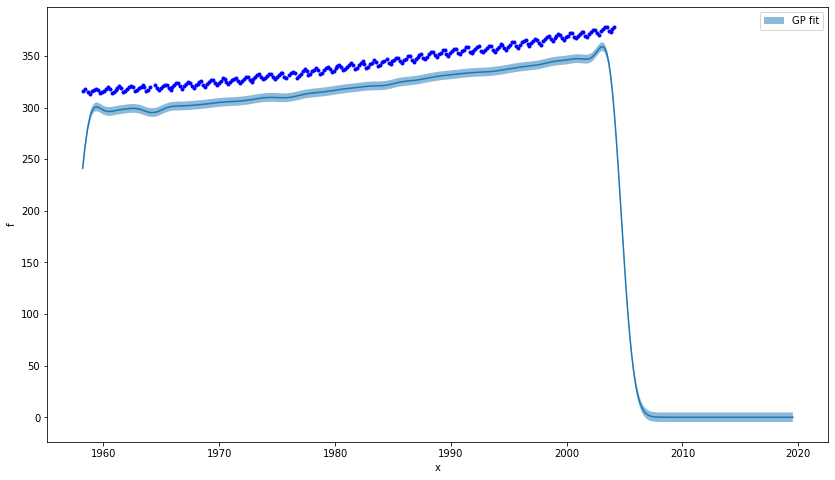

In [9]:
GPR = GP_Regression()

theta_init = {
  "log_varf": jnp.log(1.),
  "log_vary": jnp.log(1.),
  "log_scale": jnp.log(1.)}

#101.502873968226,121454.38823926545, 4.5781156963414125
initial_nll = GPR.train(theta_init,(X, Y))
print(initial_nll)
Xnew = jnp.vstack([X, Xtest])
mu_posterior, cov_posterior = GPR.posterior(X, Y, Xnew, 0)
print(mu_posterior.shape, cov_posterior.shape)

noise_matrix = 4.5781156963414125*jnp.eye(cov_posterior.shape[0],cov_posterior.shape[1])
plt.figure(figsize=(14, 8))
plot_gp(Xnew, mu_posterior, cov_posterior+noise_matrix)
plt.plot(X, Y, "b.")


### Naive SGD implementation

In [40]:
neigh = NearestNeighbors(n_neighbors=32, algorithm='kd_tree')
neigh.fit(X)
print(X.shape)
_,neigh_idx = neigh.kneighbors(X, 32)
  
neigh_idx.shape

center_idx  = jax.random.randint(key,(1,), 1, len(Y))
print(center_idx.shape)
nn_batch_indices =  neigh_idx[center_idx,]
nn_batch_X  = X[nn_batch_indices].reshape(-1,1)
nn_batch_y  = Y[nn_batch_indices.T]

nn_batch_X.shape, nn_batch_y.shape, nn_batch_indices.shape
  

(273, 1)
(1,)


((32, 1), (32, 1, 1), (1, 32))

  0%|          | 0/1000 [00:06<?, ?it/s]


TypeError: unsupported operand type(s) for +: 'DeviceArray' and 'dict'

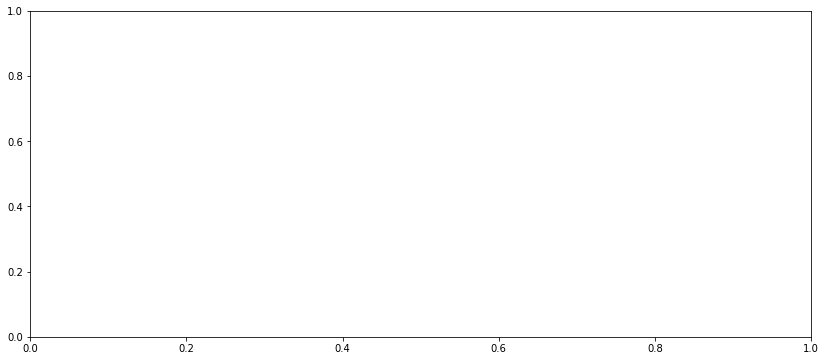

In [44]:
# initial paramters
max_iters = int(1000)
lr = 0.01
nll_iters = []

theta_init = {
  "log_varf": jnp.log(1.),
  "log_vary": jnp.log(1.),
  "log_scale": jnp.log(1.)}

batch_size = 32

nll_gradient = jax.jit(jax.value_and_grad(GPR.train, argnums = 0))

# Using adam optimizer

## Nearest Neighbour calculation

neigh = NearestNeighbors(n_neighbors=32, algorithm='kd_tree')
neigh.fit(X)
_,neigh_idx = neigh.kneighbors(X, 32)

fig, ax = plt.subplots(1,1,figsize=(14,6))

for j in range(1):
 
  if (len(X)%batch_size  == 0):
    num_batches = int(len(X)/batch_size)
  else:
    num_batches = int((len(X)/batch_size)) + 1


  for i in tqdm(range(max_iters)):
    
    ## use tfds for shuffling
    X_, Y_ = jax.random.shuffle(key, X), jax.random.shuffle(key, Y)
    batch_index = 0
  
    for k in range(num_batches):

      #optax solver
      tx = optax.adam(lr)
      opt_state = tx.init(theta_init)
      if batch_index+batch_size > len(X_):
         X_batch, Y_batch = X_[batch_index:,:], Y_[batch_index:,:]
      else:
        X_batch, Y_batch = X_[batch_index:batch_index+batch_size,:], Y_[batch_index:batch_index+batch_size,:]

      ## NN batches
      center_idx  = jax.random.randint(key,(1,), 1, len(Y))
      nn_batch_indices =  neigh_idx[center_idx,]
      nn_batch_X  = X[nn_batch_indices,].reshape(-1,1)
      nn_batch_y  = Y[nn_batch_indices].reshape(-1,1)

      batch_index += batch_size
      loss_val,grads_rs = nll_gradient(theta_init,(X_batch, Y_batch))
      loss_val,grads_nn = nll_gradient(theta_init,(nn_batch_X, nn_batch_y))

      nll_iters.append(GPR.train(theta_init,(X, Y)))
      updates,opt_state = tx.update(grads_nn, opt_state)
      theta_init = optax.apply_updates(theta_init, updates)

  print(GPR.train(theta_init,(X, Y)))
  plt.plot(nll_iters)
  plt.savefig("loss.png")
  
print(jnp.exp(theta_init["log_scale"]), jnp.exp(theta_init["log_varf"]), jnp.exp(theta_init["log_vary"]))

184.9929031919861 135944.40119169265 4.953039320334124


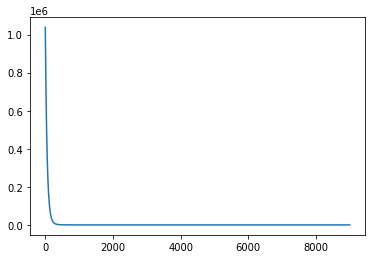

In [43]:
# nll: 616.4382302212248
plt.plot(nll_iters)
print(jnp.exp(theta_init["log_scale"]), jnp.exp(theta_init["log_varf"]), jnp.exp(theta_init["log_vary"]))

614.710405203273
(458, 1) (458, 458)


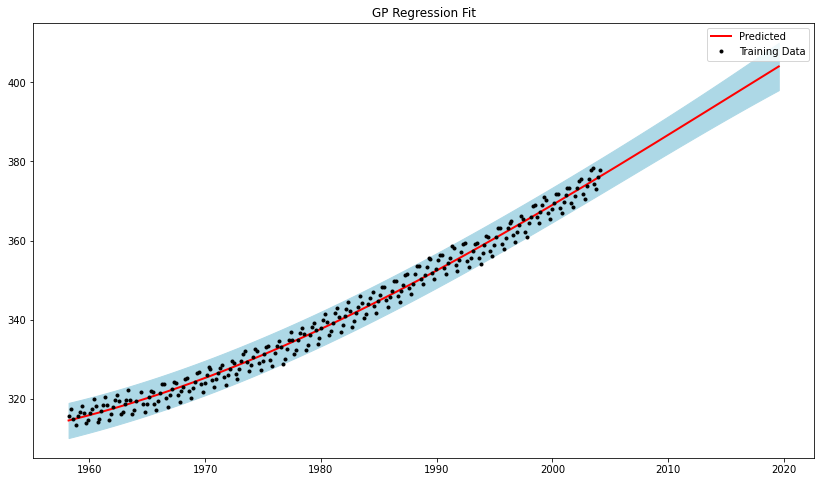

In [33]:
theta_init = 184.9929031919861 135944.40119169265 4.953039320334124
initial_nll = GPR.train(theta_init,X, Y)
print(initial_nll)
Xnew = jnp.vstack([X, Xtest])
mu_posterior, cov_posterior = GPR.posterior(X, Y, Xnew, 0)
print(mu_posterior.shape, cov_posterior.shape)


noise_matrix = jnp.exp(theta_init["log_vary"])*jnp.eye(cov_posterior.shape[0],cov_posterior.shape[1])
plt.figure(figsize=(14, 8))
# plot showing mean and covaraince of 
plt.plot(Xnew, mu_posterior, 'r', lw=2,label='Predicted')
plt.plot(X, Y, ".k", label='Training Data')

plt.fill_between(Xnew.flatten(), 
                 (mu_posterior.flatten() - 1.96*jnp.sqrt((cov_posterior+noise_matrix).diagonal().flatten())),
                 (mu_posterior.flatten() + 1.96*jnp.sqrt((cov_posterior+noise_matrix).diagonal().flatten())),
                  color='lightblue', alpha=1.0)

plt.legend()
plt.title("GP Regression Fit")
# plt.savefig("GP_noiseless_posterior.png")
plt.show()


## Played with jax.OptaxSolver not working well

In [129]:
rng = jax.random
batch_size = 8
n_iter = int(len(X)/batch_size) +1
n_samples = len(Y)

def data_iterator():
  for _ in range(n_iter):
    perm = rng.permutation(key=jax.random.PRNGKey(_), x = n_samples)[:batch_size,]
    yield X[perm], Y[perm]

import optax
from jaxopt import OptaxSolver
iterator = data_iterator()
print(iterator)
solver = OptaxSolver(opt=optax.adam(1e-1), fun=GPR.train, maxiter=2000, tol=1e-8)
res = solver.run_iterator(theta_init, iterator)

print(res, res.params)

<generator object data_iterator at 0x7f13622dcb30>
OptStep(params={'log_scale': DeviceArray(2.75924302, dtype=float64), 'log_varf': DeviceArray(2.37630734, dtype=float64), 'log_vary': DeviceArray(2.09512682, dtype=float64)}, state=OptaxState(iter_num=DeviceArray(35, dtype=int64, weak_type=True), value=DeviceArray(8096.32574616, dtype=float64), error=DeviceArray(7857.25828733, dtype=float64), internal_state=(ScaleByAdamState(count=DeviceArray(35, dtype=int32), mu={'log_scale': DeviceArray(-7684.38027594, dtype=float64), 'log_varf': DeviceArray(-14278.21536041, dtype=float64), 'log_vary': DeviceArray(-6231.52545925, dtype=float64)}, nu={'log_scale': DeviceArray(9423936.91119999, dtype=float64), 'log_varf': DeviceArray(70299092.1776808, dtype=float64), 'log_vary': DeviceArray(38653576.83328074, dtype=float64)}), EmptyState()), aux=None)) {'log_scale': DeviceArray(2.75924302, dtype=float64), 'log_varf': DeviceArray(2.37630734, dtype=float64), 'log_vary': DeviceArray(2.09512682, dtype=float

In [ ]:
# ! pip install tensorflow_probability
# ! pip install tensorflow

import tensorflow_probability as tfp
tfp.math.minimize_stateless(
 GPR.train,
  init=theta_init,
  num_steps=1000,
  optimizer=optax.adam(0.1))

In [138]:
try:
  from pyDOE import *
except ModuleNotFoundError:
  ! pip install pyDOE
  from pyDOE import *

  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=bc620bfe873bf4bc282854ab5f991032abdcc52b28d1ec02815a2f8991b95392
  Stored in directory: /home/userass/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


## Levy Dataset

In [192]:
import pandas as pd
import numpy as np
# ! pip install smt
from smt.sampling_methods import LHS

xlimits = np.array([[-10.0, 10.0], [-10.0, 10.0], [-10.0, 10.0], [-10.0, 10.0]])
random_state = np.random.seed(0)
sampling = LHS(xlimits=xlimits, random_state=0 )
num = 10000
# print(num)

x = sampling(num)
print(x[:,0])
X = pd.DataFrame(x)
# print(0)
w = []
for ii in X.columns:
    w.append(1 + (X[ii] - 1) / 4)

term1 = (np.sin(np.pi * w[0])) ** 2
term3 = (w[-1] - 1) ** 2 * (1 + (np.sin(2 * np.pi * w[-1])) ** 2)

sum = 0
for ii in range(len(X.columns) - 1):
    wi = w[ii]
    new = (wi - 1) ** 2 * (1 + 10 * (np.sin(np.pi * wi + 1)) ** 2)
    sum = sum + new
y = term1 + sum + term3
  # return X, y

[-1.601 -5.473  3.479 ... -8.685  0.921  0.785]


In [195]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0
)
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
y_train = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test = scaler.transform(np.array(y_test).reshape(-1, 1))
X_train.to_csv("Datasets/Levy/X_train.csv.gz")
X_test.to_csv("Datasets/Levy/X_test.csv.gz")
pd.DataFrame(y_train).to_csv("Datasets/Levy/y_train.csv.gz")
pd.DataFrame(y_test).to_csv("Datasets/Levy/y_test.csv.gz")
# X_train, X_test, y_train, y_test = torch.tensor(np.array([X_train])).squeeze(),torch.tensor(np.array([X_test])).squeeze(),torch.tensor(np.array([y_train])).squeeze(),torch.tensor(np.array([y_test])).squeeze()
# return X_train, X_test, y_train, y_test

In [204]:
dirname = "Datasets/Levy"
X_train = pd.read_csv(dirname+"/X_train.csv.gz").iloc[:,1:]
X_test = pd.read_csv(dirname+"/X_test.csv.gz").iloc[:,1:]
y_train = pd.read_csv(dirname+"/y_train.csv.gz").iloc[:,1:]
y_test = pd.read_csv(dirname+"/y_test.csv.gz").iloc[:,1:]

X_train, X_test = jnp.array(jnp.array([X_train])).squeeze(),jnp.array([X_test]).squeeze()
y_train, y_test = jnp.array([y_train]).squeeze(),jnp.array([y_test]).squeeze()

In [223]:
X_train.shape

(6000, 4)

In [268]:
class GP_Regression:

  def rbf(self, x, x_star, len_scale,varf):
    return (varf)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  
    
  def periodic_kernel(self, x, xstar, len_scale, varf, period):
    return (varf)*(jnp.exp((-1/2*(len_scale**2)) * jnp.square(jnp.sin(jnp.pi * (x-xstar)/period))))  

  def rbf(self, x, x_star, len_scale, varf):
    sqdist = jnp.sum(x**2,1) + jnp.sum(x_star**2,1) - 2*jnp.dot(x, x_star.T)
    return varf*jnp.exp(-.5 * (1/len_scale) * sqdist)

  def train(self,theta,data):
    x, y = data
    self.len_scale = jnp.exp(theta["log_scale"])
    self.varf = jnp.exp(theta["log_varf"])
    k = self.rbf(x,x,self.len_scale, self.varf)
    self.k = k + ( jnp.exp(theta["log_vary"]) * jnp.eye(len(x)))
    mean_vec= jnp.zeros(y.shape[0])
    dist = distrax.MultivariateNormalFullCovariance(mean_vec, self.k)
    dist_logprob = dist.log_prob(y.reshape(-1,))
    return -dist_logprob
  

  def posterior(self, X, y, X_test, mu_prior):
    L = jnp.linalg.cholesky(self.k)
    kstar = self.rbf(X, X_test, self.len_scale, self.varf)
    kstar_star = self.rbf(X_test, X_test, self.len_scale, self.varf)
    # posterior mean
    alpha = jnp.linalg.solve(L.T, (jnp.linalg.solve(L, (y - mu_prior))))
    self.mu_posterior =  mu_prior + jnp.dot(kstar.T, alpha)
    # posterior covarinace
    v = jnp.linalg.solve(L, kstar)
    self.cov_posterior = kstar_star - jnp.dot(v.T, v)
    return self.mu_posterior, self.cov_posterior

  def posterior_samples(self, key):
    # prior mean equal to zero
    print(self.mu_posterior.shape)
    posterior = distrax.MultivariateNormalFullCovariance(self.mu_posterior.reshape(-1,),self.cov_posterior)
    f_post = posterior.sample(seed=key, sample_shape = (1,))
    f_post = f_post.T
    return f_post

In [1]:
# def rbf(self, x, x_star, len_scale, varf):
#   sqdist = jnp.sum(x**2,1) + jnp.sum(x_star**2,1) - 2*jnp.dot(x, x_star.T)
#   return varf*jnp.exp(-.5 * (1/len_scale) * sqdist)
  

GPR = GP_Regression()

theta_init = {
  "log_varf": jnp.log(1.),
  "log_vary": jnp.log(1.),
  "log_scale": jnp.log(1.)}

#101.502873968226,121454.38823926545, 4.5781156963414125
initial_nll = GPR.train(theta_init,(X_train, y_train))
print(initial_nll)
Xnew = jnp.vstack([X_train, X_test])
mu_posterior, cov_posterior = GPR.posterior(X_train, y_train, Xnew, 0)
print(mu_posterior.shape, cov_posterior.shape)

noise_matrix = 4.5781156963414125*jnp.eye(cov_posterior.shape[0],cov_posterior.shape[1])
plt.figure(figsize=(14, 8))
plot_gp(Xnew, mu_posterior, cov_posterior+noise_matrix)
plt.plot(X_train, y_train, "b.")

NameError: name 'GP_Regression' is not defined